In [ ]:
import cv2
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import math
# Initial Data
N = 6
K = 1

# TRAIN DATA
grayImg = []
grayImg.append(cv2.resize(cv2.imread('/content/1.jpg',0),(400,300)))
grayImg.append(cv2.resize(cv2.imread('/content/2.jpg',0),(400,300)))
grayImg.append(cv2.resize(cv2.imread('/content/3.jpg',0),(400,300)))
grayImg.append(cv2.resize(cv2.imread('/content/4.jpg',0),(400,300)))
grayImg.append(cv2.resize(cv2.imread('/content/5.jpg',0),(400,300)))
grayImg.append(cv2.resize(cv2.imread('/content/6.jpg',0),(400,300)))

# Median filter - MASK[5,5]
def median_filter(grayImg,N):
  medImg = []
  for ii in range (N):
      medImg.append(scipy.signal.medfilt2d(grayImg[ii],5))
      # looping j times
      for jj in range (K):
          medImg[ii] = (medImg[ii] + scipy.signal.medfilt2d(grayImg[ii],5)).astype(np.uint8)
  return medImg

# Create Structuring Element for 0,30,60,90,120,150 degres
def Pt(x0, y0, x1, y1):
   points = []
   dx, dy = abs(x1 - x0), abs(y1 - y0)
   x, y = x0, y0
   sx = -1 if x0 > x1 else 1
   sy = -1 if y0 > y1 else 1
   if dx > dy:
      err = dx /2
      while x != x1:
         points.append((x, y))
         err -= dy
         if err < 0:
            y += sy
            err += dx
         x += sx
   else:
      err = dy / 2.0
      while y != y1:
         points.append((x, y))
         err -= dx
         if err < 0:
            x += sx
            err += dy
         y += sy
   points.append((x, y))
   return points

def strel_line(length, degrees):
   if length >= 1:
      theta = degrees*np.pi/180
      x = round((length - 1) / 2 * np.cos(theta))
      y = -round((length - 1) / 2 * np.sin(theta))
      points = Pt(-x, -y, x, y)
      points_x = [point[0] for point in points]
      points_y = [point[1] for point in points]
      n_rows = int(2 * max([abs(point_y) for point_y in points_y]) + 1)
      n_columns = int(2 * max([abs(point_x) for point_x in points_x]) + 1)
      strel = np.zeros((n_rows, n_columns))
      rows = ([point_y + max([abs(point_y) for point_y in points_y]) for point_y in points_y])
      columns = ([point_x + max([abs(point_x) for point_x in points_x]) for point_x in points_x])
      idx = []
      for x in zip(rows, columns):
         idx.append(np.ravel_multi_index((int(x[0]), int(x[1])), (n_rows, n_columns)))
      strel.reshape(-1)[idx] = 1
      strel = strel.astype(np.uint8)
   return strel

def opening_img(medImg,N):
  SE = []
  for ii in range (N):
    SE.append(strel_line(15,ii*30))
  imgOpen=np.zeros([6,300,400])
  imgOverlap = np.zeros([6,300,400])
  # Image opening in the six direction for each gray level image and Overlap Image to Single one
  for ii in range (N):
      for j in range (6):
          imgOpen[j]=cv2.morphologyEx(medImg[ii], cv2.MORPH_OPEN, SE[j])
          if j==5:
              imgOverlap[ii]=imgOpen[0]
              for l in range (1,5):
                  imgOverlap[ii] = cv2.addWeighted(imgOverlap[ii],0.7,imgOpen[l],0.3,0.0) 
                  # np.dstackdst = cv.addWeighted(src1, alpha, src2, beta, 0.0)
  return imgOverlap

def threshold(imgOverlap,th, N, kkk):
  imgBw = []
  for ii in range (N):
     (thresh, blackAndWhiteImage) = cv2.threshold(imgOverlap[ii], th, 255, cv2.THRESH_BINARY)
     if kkk == True:
       for jj in range (blackAndWhiteImage.shape[0]):
         for kk in range (blackAndWhiteImage.shape[1]):
           if blackAndWhiteImage[jj][kk] == np.uint8(255):
             blackAndWhiteImage[jj][kk] = np.uint8(0)
           else:
             blackAndWhiteImage[jj][kk] = np.uint8(255)
     imgBw.append(blackAndWhiteImage)
  return imgBw

def gaussblur(sigma, grayImg):
  k=[]
  for image in grayImg:
    image = cv2.resize(image, (0, 0), fx=2, fy=2)
    sigma1 = np.sqrt(max((sigma ** 2) - 1, 0.01))
    k.append(cv2.GaussianBlur(image, (0, 0), sigmaX=sigma1, sigmaY=sigma1))
  return k

def laplacian(imgg):
  jk=[]
  ddepth = cv2.CV_16S
  for src_gray in imgg:
    dst = cv2.Laplacian(src_gray, ddepth, ksize=5)
    abs_dst = cv2.convertScaleAbs(dst)
    jk.append(abs_dst)
  return jk

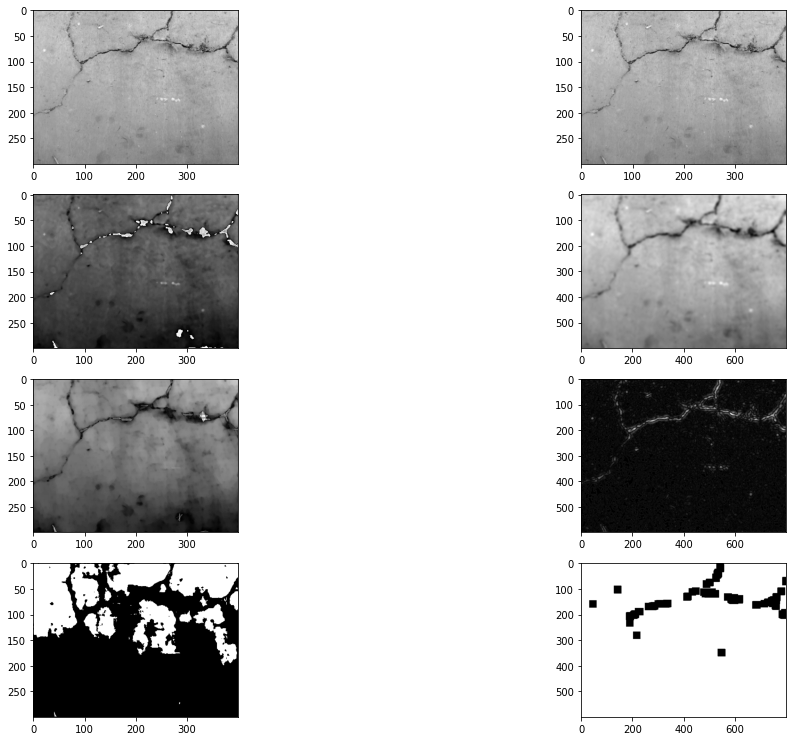

In [ ]:
def pre_processing(grayImg, N):
  medImg = median_filter(grayImg,N)
  imgOverlap = opening_img(medImg,N)
  imgBw = threshold(imgOverlap,85, N, kkk=False)
  return imgBw, medImg, imgOverlap

def pre_processing2(grayImg,N):
  medImg2 = gaussblur(3.8, grayImg)
  imgOverlap2 = laplacian(medImg2)
  imgBw21 = threshold(imgOverlap2,80, N, kkk=True)
  kernel = np.ones((5,5),np.uint8)
  kernel2 = np.ones((8,8),np.uint8)
  #imgBw2 = cv2.dilate(imgBw21, kernel, iterations = 1)
  imgBw2 =[]
  for im in imgBw21:
    d = cv2.dilate(im, kernel, iterations = 1)
    imgBw2.append(cv2.erode(d, kernel2, iterations = 4))#cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel))
  return imgBw2, medImg2, imgOverlap2 
imgBw, medImg, imgOverlap = pre_processing(grayImg,6)
imgBw2, medImg2, imgOverlap2 = pre_processing2(grayImg,6)
fig, plot = plt.subplots(4, 2, figsize=(18,13))
plot[0,0].imshow(grayImg[1],cmap='gray')
plot[1,0].imshow(medImg[1],cmap='gray')
plot[2,0].imshow(imgOverlap[1],cmap='gray')
plot[3,0].imshow(imgBw[1],cmap ='gray')
plot[0,1].imshow(grayImg[1],cmap='gray')
plot[1,1].imshow(medImg2[1],cmap='gray')
plot[2,1].imshow(imgOverlap2[1],cmap='gray')
plot[3,1].imshow(imgBw2[1],cmap ='gray')

In [ ]:
from skimage import measure
from skimage.measure import label, regionprops, regionprops_table
# Prepare properties image region (Eccentricity and Area) for crack
def image_region_props(imgBw2, N):
  imgProp = []
  area = []
  eccentricity = []
  majorAxis = []
  minorAxis = []
  for i in range (N):
     labels = measure.label(imgBw2[i], background=1) # same image_binary as above
     imgProp.append(measure.regionprops(labels))
     areaProp = []
     eccentricityProp = []
     majorAxisProp = []
     minorAxisProp = []
     for propss in imgProp[i]:
       areaProp.append(propss.area)
       eccentricityProp.append(propss.eccentricity)
       majorAxisProp.append(propss.major_axis_length)
       minorAxisProp.append(propss.minor_axis_length)
     area.append(areaProp)
     eccentricity.append(eccentricityProp)
     majorAxis.append(majorAxisProp)
     minorAxis.append(minorAxisProp)   
  for ii in range (N):
    ma = max(area[ii])
    ma1 = max(majorAxis[ii])
    ma2 = max(minorAxis[ii])
    for jj in range (np.size(area[ii])):
      area[ii][jj] = 100000*area[ii][jj]/ma
      majorAxis[ii][jj] = 1000*majorAxis[ii][jj]/ma1
      minorAxis[ii][jj] = 1000*minorAxis[ii][jj]/ma2
  return area, majorAxis, minorAxis, eccentricity

area, majorAxis, minorAxis, eccentricity = image_region_props(imgBw2, 6)
print('',area[0]) # Total occupied area in image 1
print('',area[1]) 
print('',minorAxis[2]) # Values of minor axes of continous curves formed in image 3
print('',majorAxis[3]) 
print('',eccentricity[4]) # Values of eccentricity of continous curves formed in image 5
print('',eccentricity[5])

 [100000.0, 46.062874781930844]
 [100000.0, 857.9139517841289, 109.14879438182595, 205.4565541304959, 485.96674172030015, 1216.7987300659543, 560.5775808819134, 598.2150961859913, 728.1752225594839, 186.19500218076192, 695.8512388277463, 234.90237492721567, 186.19500218076192, 205.2351569816484]
 [28.300052718364817, 1000.0]
 [825.171787986956, 43.24753554072907, 33.51793508181073, 47.20152376529644, 35.74093103315697, 35.76212662072662, 911.6386568971875, 1000.0, 33.51793508181073, 33.51793508181073, 36.9299160576068, 36.86953114633973, 357.3179820149544, 123.9596135808637, 75.30446061162397, 109.45328857117481, 38.05169607357611, 38.151919412725356, 10.343859333870636, 33.51793508181073, 2.003079746779656]
 [0.6614383445150561]
 [0.7833866415710364, 0.9638880735491598, 0.0790157981542957, 0.6946889362332874, 0.3500540705420341, 0.0, 0.2927576676951333, 0.0, 0.0790157981542957, 0.13107076001213824]


In [ ]:
def count_props(area, majorAxis, minorAxis, eccentricity, N):
  area1, ecc1, max1, mix1 = [],[],[],[]  # Area<=1.5
  for ii in range (N):
    counter1,counter2,counter3,counter4 = 0,0,0,0
    for jj in range (np.size(area[ii])):
      if area[ii][jj] < 50000:
        # Excluding the disproportionate values, the values of rest are added
        counter1 += area[ii][jj]
      if eccentricity[ii][jj] > 0.1:
        counter2 += eccentricity[ii][jj]
      if majorAxis[ii][jj] < 999:
        counter3 += majorAxis[ii][jj]
      if minorAxis[ii][jj] < 999:
        counter4 += minorAxis[ii][jj]
    mix1.append(counter4)
    max1.append(counter3)
    ecc1.append(counter2)
    area1.append(counter1)
  return mix1, max1, ecc1, area1

mix1, max1, ecc1, area12 = count_props(area, majorAxis, minorAxis, eccentricity, 6)
print('',mix1) # the values of summed up minor axes for all training set images
print('',max1)
print('',area12)
print('',ecc1)

 [21.611868278182506, 725.9950055924211, 28.300052718364817, 2875.2395627431265, 0, 2425.8584782317976]
 [21.22236579761224, 1038.374386771496, 21.225177458457868, 2861.2196487208107, 0, 2418.6936013291474]
 [46.062874781930844, 6270.631446808226, 60.24460560629212, 35575.08051439879, 0, 43102.198149513824]
 [1.3069377590167424, 8.979031247604109, 0.6614323017204806, 10.855887315985484, 0.6614383445150561, 3.2158461496027897]


In [ ]:
def data_x(mix1, max1, ecc1, area12, N):
  datax = []
  for jj in range (N):
    datax.append([mix1[jj], max1[jj], area12[jj], ecc1[jj]])
  return datax

In [ ]:
def print_result(mix1, max1, ecc1, area1, N):
  abb= np.zeros(N)
  for ii in range (N):
    abb[ii] = mix1[ii]+max1[ii]+area1[ii]+ecc1[ii]
    # Numerical barrier set by analysing the statistics to predict whether image has cracks or not
    if abb[ii]>3168:
      abb[ii] = 1
    else :
      abb[ii] = 0
  return abb
abb = print_result(mix1, max1, ecc1, area12, 6)
print('',abb)
# 1 Depicts that the given surface has cracks and 0 depicts the surface doesnt have cracks

 [0. 1. 0. 1. 0. 1.]


In [ ]:
def CRACK_DETECTION(grayImg,N):
  imgBw2, medImg2, imgOverlap2 = pre_processing2(grayImg,N)
  area, majorAxis, minorAxis, eccentricity = image_region_props(imgBw2, N)
  mix1, max1, ecc1, area1 = count_props(area, majorAxis, minorAxis, eccentricity, N)
  abb = print_result(mix1, max1, ecc1, area1, N)
  return abb, mix1, max1, ecc1, area1

In [ ]:
# Using CRACK DETECTION to detect cracks in test set images 7 & 8 
Immg = []
Immg.append(cv2.resize(cv2.imread('/content/7.jpg',0),(400,300)))
Immg.append(cv2.resize(cv2.imread('/content/8.jpg',0),(400,300)))
abb1, mix12, max12, ecc12, area122= CRACK_DETECTION(Immg,2)
print('',abb1)
#plt.imshow(imgBw2[1],cmap='gray')

 [0. 1.]


In [ ]:
def ML_model(grayImg,Immg):
  abb12, mix123, max123, ecc123, area123=CRACK_DETECTION(grayImg, 6)
  abb13, mix13, max13, ecc13, area13= CRACK_DETECTION(Immg,2)
  dxx = data_x(mix123, max123, ecc123, area123, 6)
  dxx2 = data_x(mix13, max13, ecc13, area13, 2)
  for i in dxx2 : 
    dxx.append(i)
  datay = np.concatenate((abb12,abb13))
  return dxx, datay

In [ ]:
# Using k neighbors classification algorithm to classify crack and no crack images
from sklearn.model_selection import train_test_split

ML_model1x, ML_model1y = ML_model(grayImg,Immg)
X_train, X_test, y_train, y_test = train_test_split(ML_model1x, ML_model1y, random_state=0)
print('',X_test)

 [[506.1617852264918, 432.6728090162132, 2219.657266007492, 3.8500575393257734], [28.300052718364817, 21.225177458457868, 60.24460560629212, 0.6614323017204806]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)

l = knn.fit(X_train, y_train)
knn.score(X_test, y_test)

1.0

In [ ]:
kaks = cv2.imread('/content/2.PNG',0)
abb1211, mix1231, max1231, ecc1231, area1231=CRACK_DETECTION(kaks, 1)
XX = [[mix1231[0], max1231[0], ecc1231[0], area1231[0]]]
Crack_prediction = l.predict(XX)
Crack_prediction
#print('',mix1231[0])

array([0.])

In [ ]:
# Using SVM algorithm to classify crack and no crack images
from sklearn.svm import LinearSVC

clf = LinearSVC().fit(X_train, y_train)
Crack_prediction = clf.predict(XX)
Crack_prediction

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([0.])

In [ ]:
from sklearn.linear_model import LogisticRegression

clf11 = LogisticRegression().fit(X_train, y_train)
Crack_prediction = clf11.predict(XX)
Crack_prediction

array([0.])